In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from bmel.data.fastmri import FastVolumeDS
from monai.visualize import matshow3d
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import ipywidgets as widgets
from IPython.display import display
from scipy.signal import savgol_filter
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
import tqdm

In [8]:
ds = FastVolumeDS()
img = ds[0]['img'].flatten().numpy()

  0%|          | 0/948 [00:00<?, ?it/s]

 11%|█         | 100/948 [00:09<01:20, 10.48it/s]


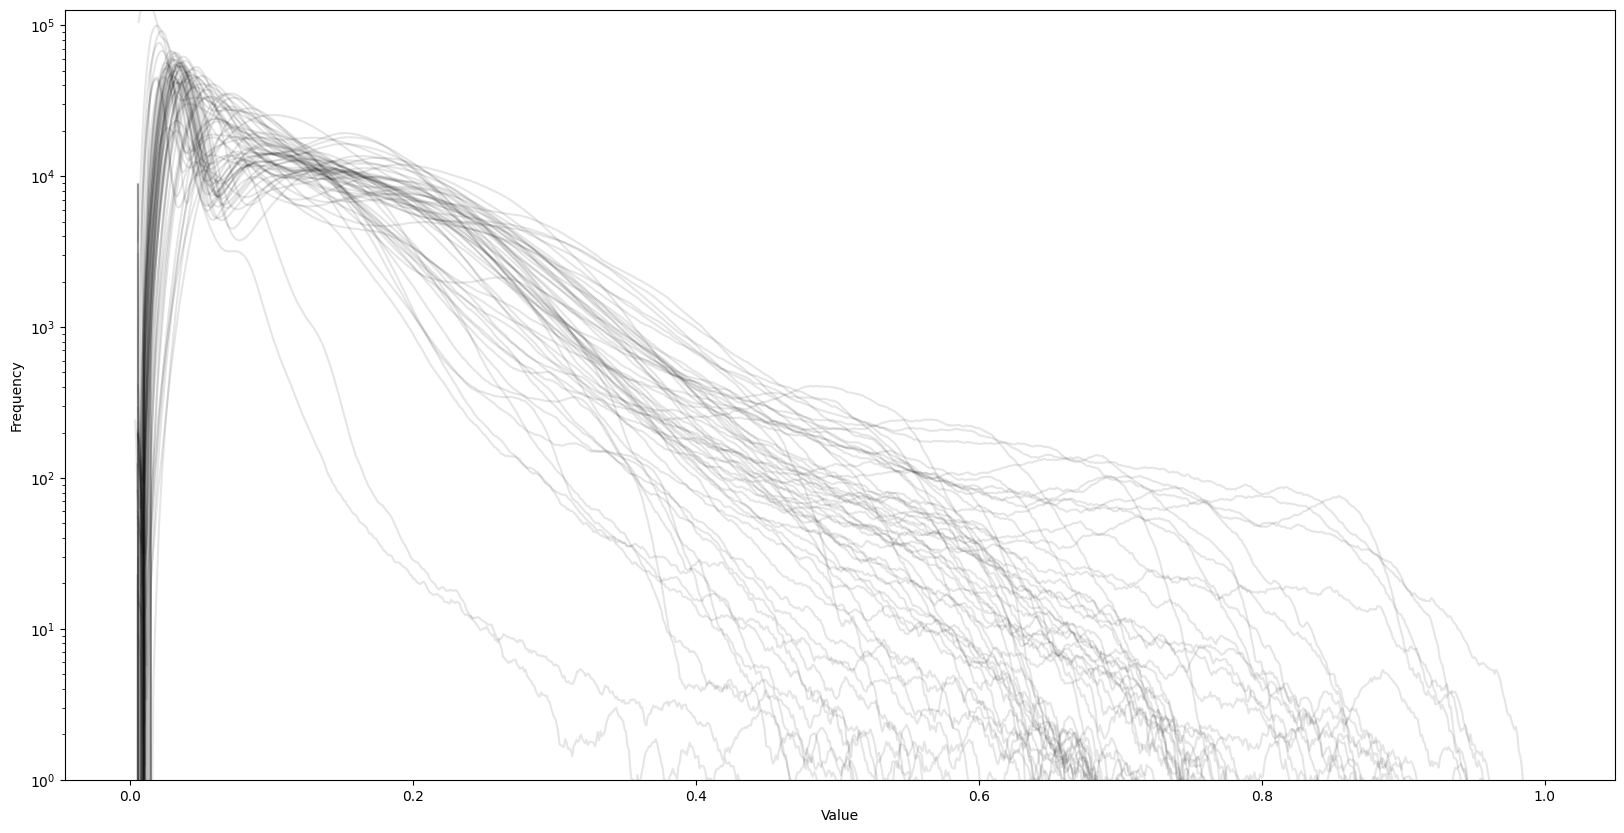

In [9]:
plt.figure(figsize=(20, 10))

for ndx, d in enumerate(tqdm.tqdm(ds)):
    if ndx == 100: break
    if d['acquisition'] != 'CORPDFS_FBK': continue
    img = d['img'].flatten().numpy()

    hist, bin_edges = np.histogram(img, bins=1000)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Apply Gaussian filter
    # hist_gaussian_filter = gaussian_filter(hist, sigma=3)


    # Apply Savitzky-Golay filter
    window_length = 27
    polyorder = 3
    hist_savgol = savgol_filter(hist, window_length, polyorder)


    # Apply Kernel Density Estimation (IS VERY POOR!)
    # for bw_method in [0.1, 0.5, 1, 'scott', 'silverman']:
    #     kde = gaussian_kde(img.numpy().flatten(), bw_method=bw_method)  # Adjust the bandwidth by changing the bw_method
    #     kde_values = kde(bin_centers)
    #     plt.plot(bin_centers, kde_values, label=f'Kernel Density Estimation {bw_method}')


    # Plot histogram as a line plot
    # plt.plot(bin_centers, hist, label='Raw', alpha=0.25, c='k')
    # plt.plot(bin_centers, hist_gaussian_filter, label='Gaussian Filter', alpha=0.5)
    plt.plot(bin_centers[5:], hist_savgol[5:], label='Savitsky-Golay', alpha=0.1, c='k')
    # plt.plot(bin_centers, kde_values, label='Kernel Density Estimation')
    plt.yscale('log')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.ylim(bottom=1)
    # plt.legend()

    # Find peaks
    # peaks, _ = find_peaks(hist_savgol, prominence=10, distance=25)
    # inverted_hist = -hist_savgol
    # valleys, _ = find_peaks(inverted_hist, prominence=10, distance=25)
    # valleys = [v for v in valleys if v > peaks[0]] # remove first valley
    # # peak_vals = sorted([bin_centers[p] for p in peaks] + [bin_centers[v] for v in valleys])
    # peaks = sorted(list(peaks) + list(valleys))
    # peak_x = [bin_centers[peak] for peak in peaks]
    # peak_y = [hist_savgol[peak] for peak in peaks]

    # for i, peak in enumerate(peaks):
    #     plt.axvline(peak_x[i], alpha=0.1)
    #     plt.text(peak_x[i], peak_y[i], f'{float((img < peak_x[i]).sum() / img.size):.2f}')
    #     # plt.text(0,1,'yay')
    # plt.scatter(bin_centers[peaks], hist_savgol[peaks], s=5)

plt.show()

In [10]:
list(peaks)

NameError: name 'peaks' is not defined

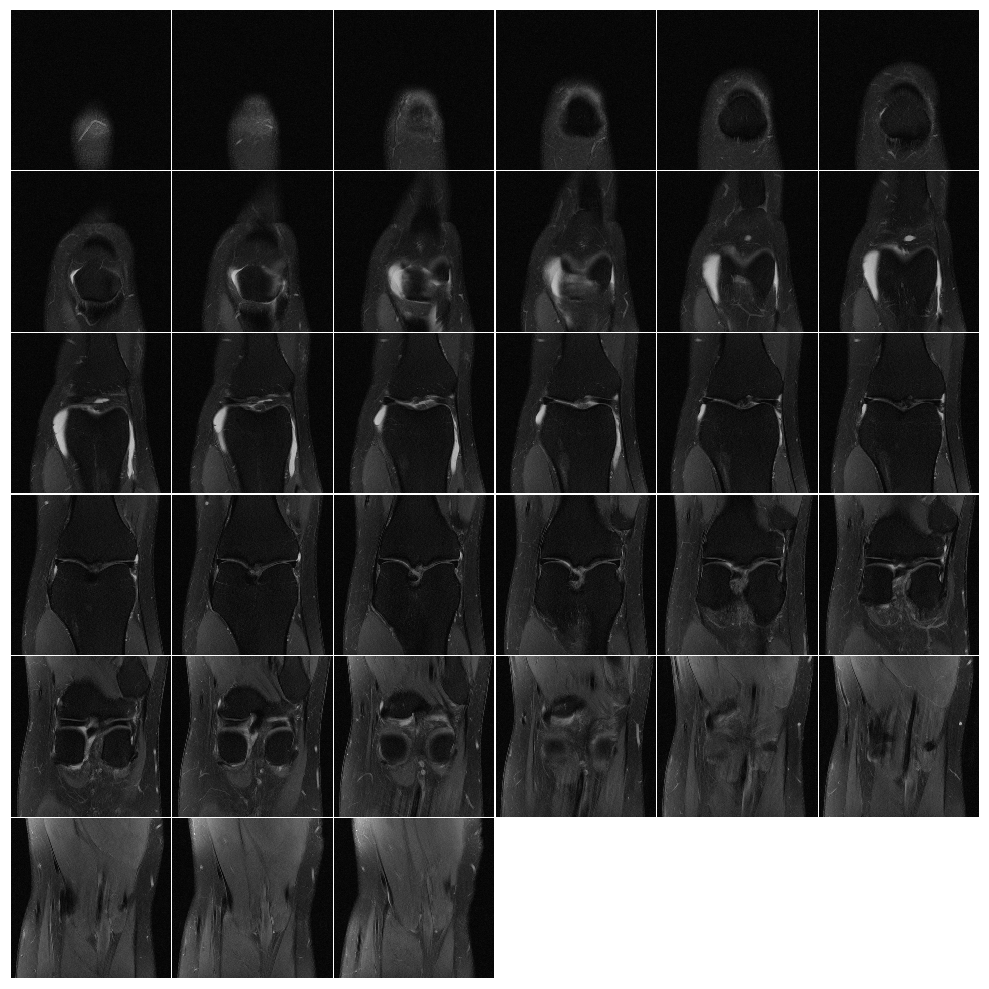

In [ ]:
fig, ax = matshow3d(img, cmap='gray')


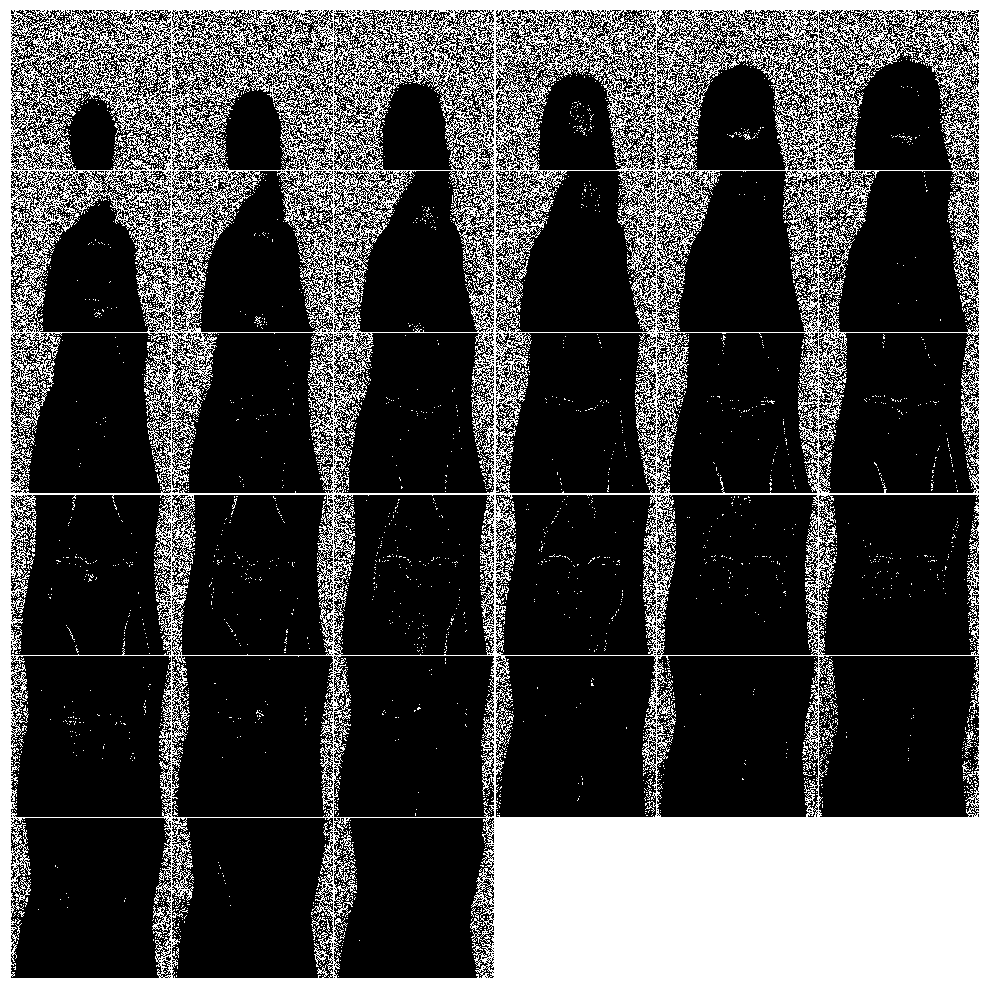

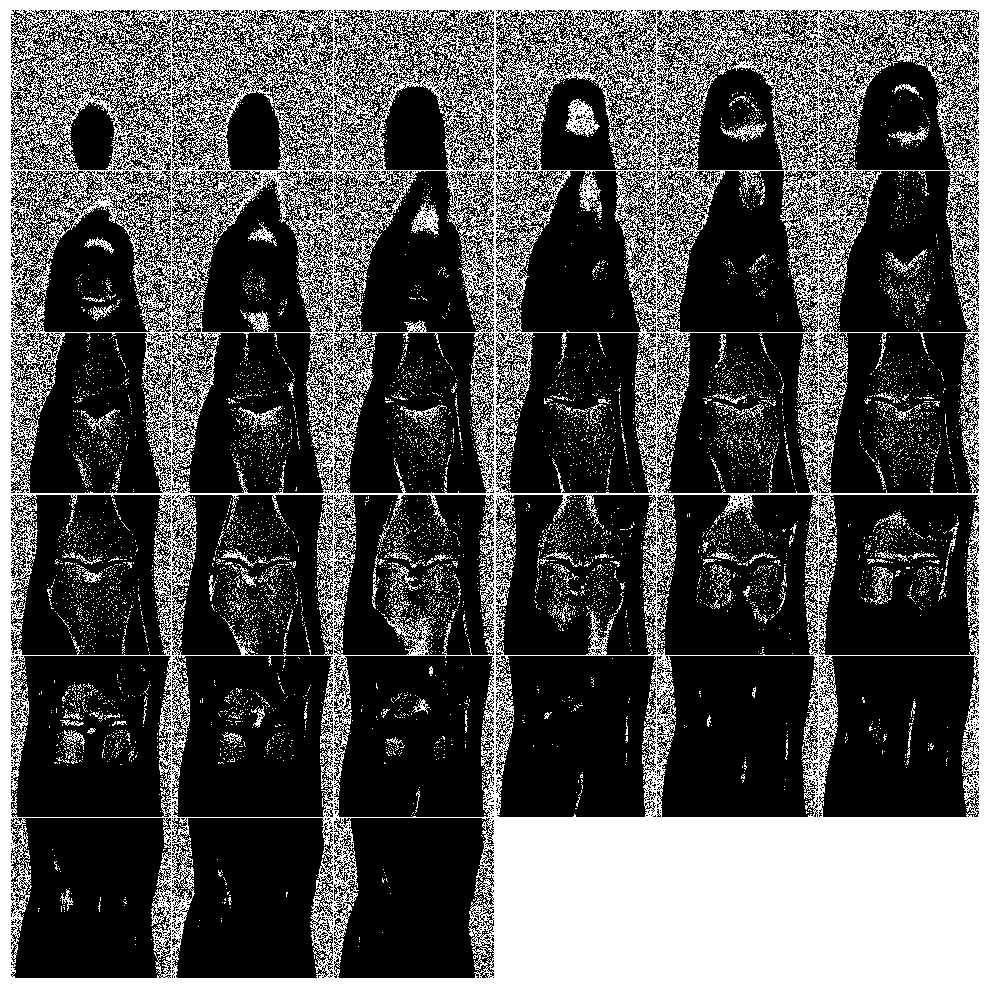

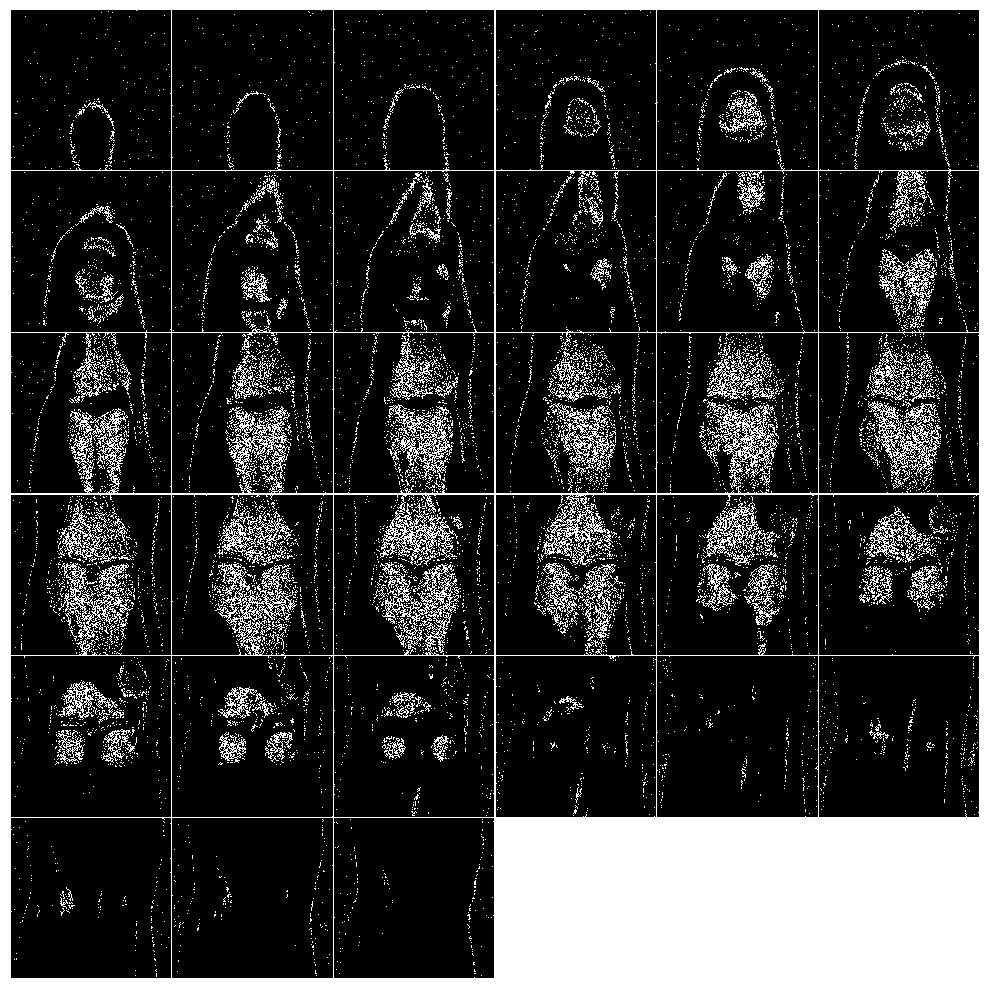

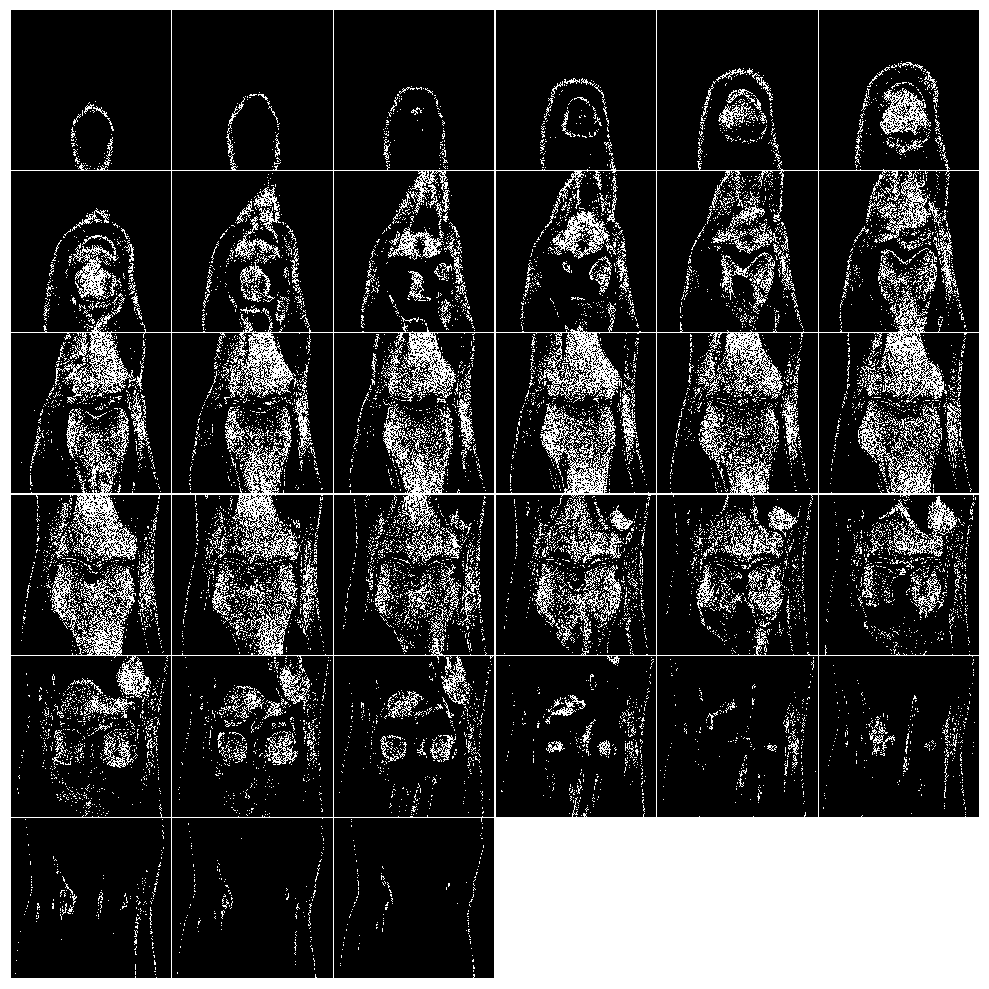

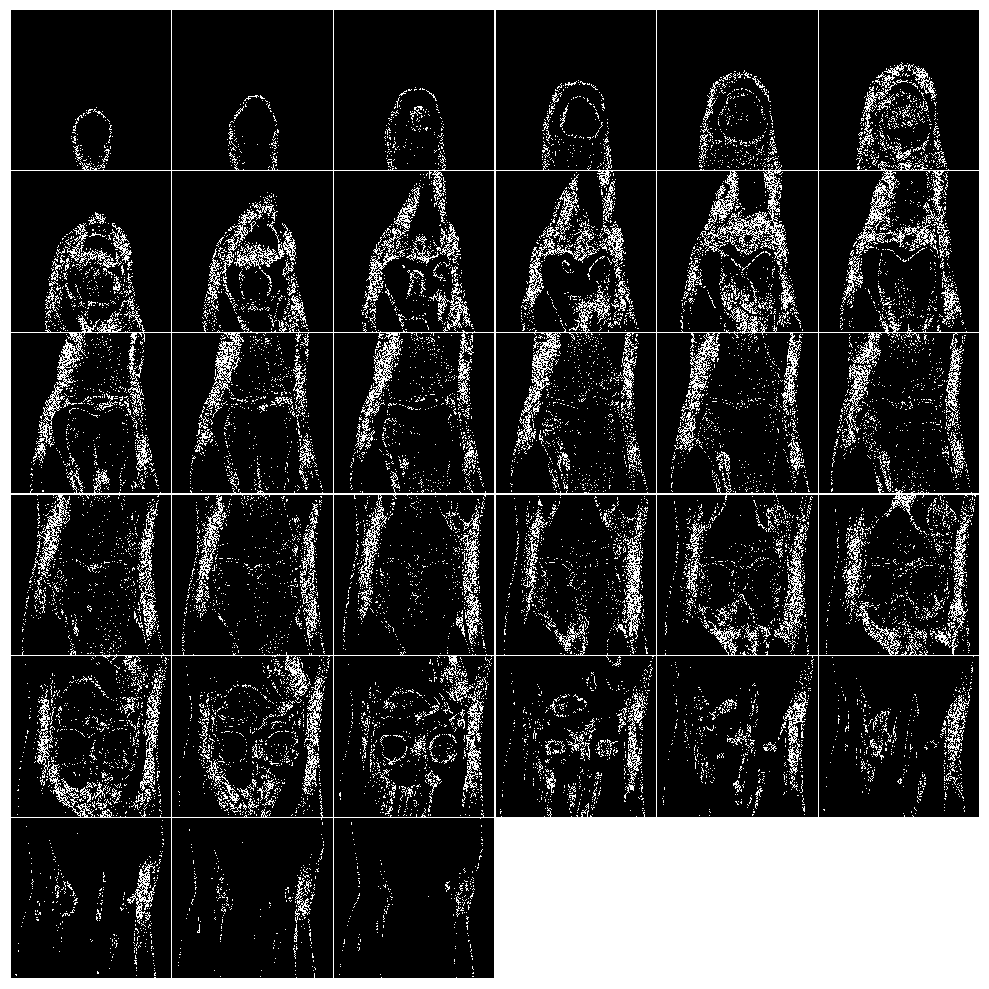

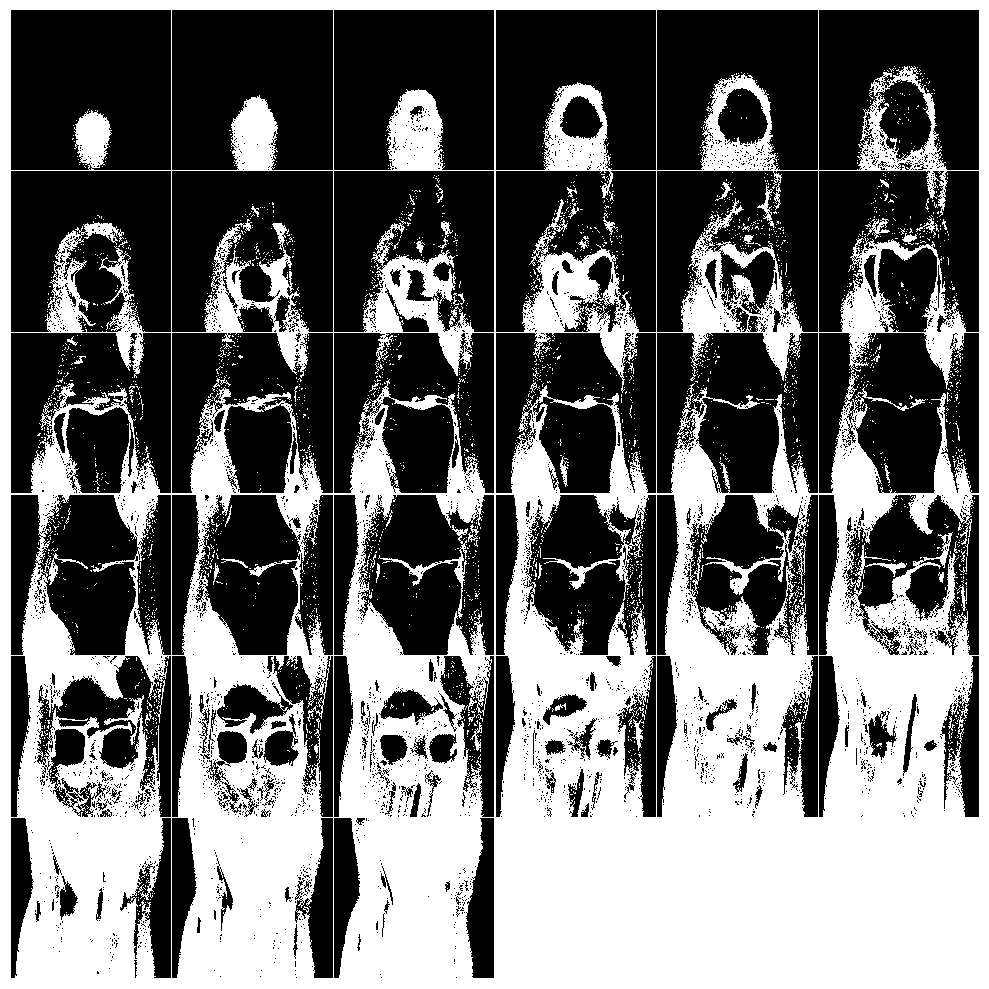

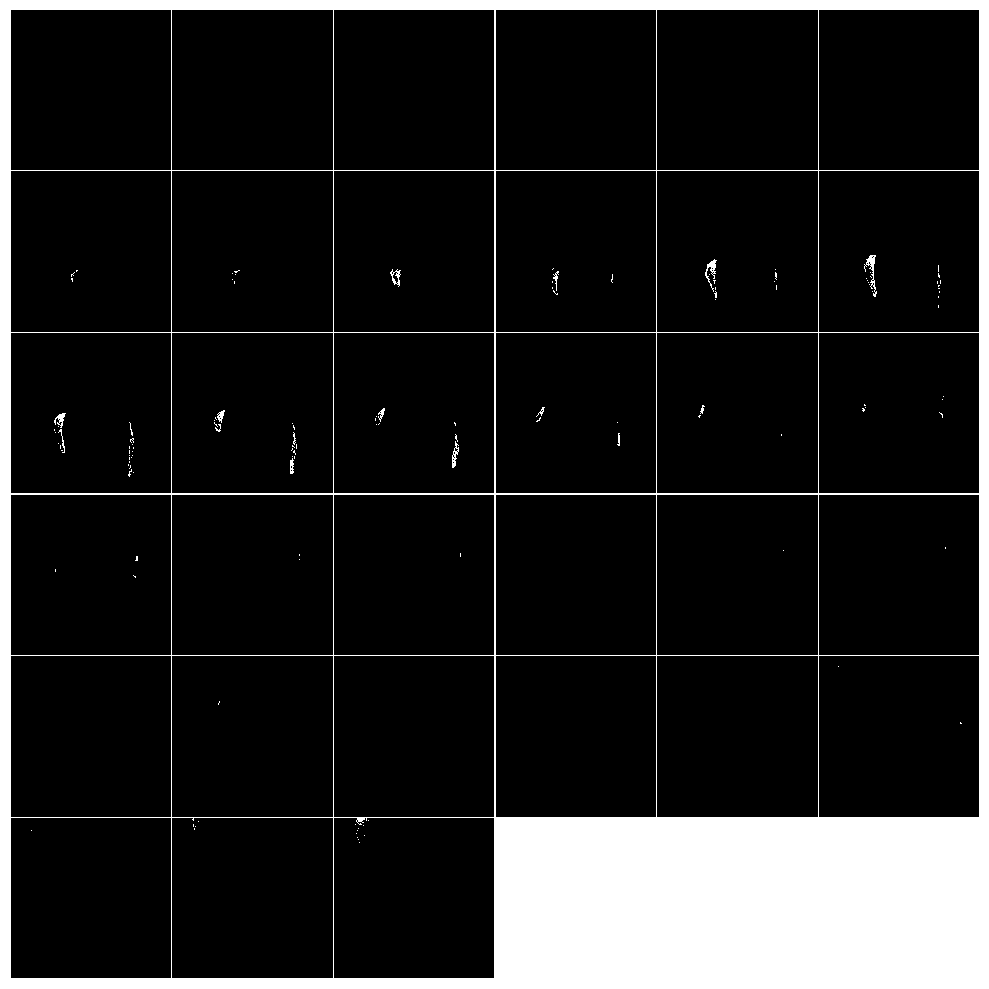

In [ ]:
for ndx in range(len(peak_vals) - 1):
    fig, ax = matshow3d((img > peak_vals[ndx]).to(bool) & (img < peak_vals[ndx+1]).to(bool), cmap='gray')
    plt.show()
# fig, ax = matshow3d(img < peak_vals[1], cmap='gray')